In [7]:
import dataset_utils
import layers

c:\Users\maxde\anaconda3\envs\final311\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [8]:
dataset = dataset_utils.SDFDataset("./cars100")

In [9]:
from torch.utils.data import DataLoader, random_split
import torch

# make dataloaders
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4, pin_memory=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = layers.KLAutoEncoder().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [10]:
import trainer as t
# # from importlib import reload
# # reload(t)
t.train(model, train_loader, val_loader, optimizer, device, num_epochs=10)

100%|██████████| 20/20 [00:53<00:00,  2.69s/it]


Epoch 1/10 - Validation Loss: 0.383432


100%|██████████| 20/20 [00:51<00:00,  2.58s/it]


Epoch 2/10 - Validation Loss: 0.109812


100%|██████████| 20/20 [00:51<00:00,  2.56s/it]


Epoch 3/10 - Validation Loss: 0.114131


100%|██████████| 20/20 [00:52<00:00,  2.60s/it]


Epoch 4/10 - Validation Loss: 0.110897


100%|██████████| 20/20 [00:53<00:00,  2.66s/it]


Epoch 5/10 - Validation Loss: 0.108318


100%|██████████| 20/20 [00:52<00:00,  2.64s/it]


Epoch 6/10 - Validation Loss: 0.107487


100%|██████████| 20/20 [00:53<00:00,  2.65s/it]


Epoch 7/10 - Validation Loss: 0.128498


100%|██████████| 20/20 [00:54<00:00,  2.71s/it]


Epoch 8/10 - Validation Loss: 0.130894


100%|██████████| 20/20 [00:53<00:00,  2.66s/it]


Epoch 9/10 - Validation Loss: 0.142823


100%|██████████| 20/20 [00:55<00:00,  2.79s/it]


Epoch 10/10 - Validation Loss: 0.122114


In [88]:
def test_model(example):
    # Random indices: shape [B, points_used]
    samples_idx = torch.randperm(example.shape[0])[:2048]
    query_idx = torch.randperm(example.shape[0])[:10000]

    samples = example[samples_idx].unsqueeze(0) # [1, 2048, 4]
    queries = example[query_idx].unsqueeze(0) # [1, 2048, 4]
    # queries = example.unsqueeze(0)

    sample_pos = samples[:, :, :3].to(device) # [B, points_used, 3]
    query_pos = queries[:, :, :3].to(device) # [B, points_used, 3]

    outputs = model(sample_pos, query_pos)
    sdf_values = outputs['sdf'].unsqueeze(-1)  # add extra dimension at the end, [1, 512, 1]

    combined = torch.cat([query_pos, sdf_values], dim=-1)  # shape [1, 512, 4]

    return combined

def totally_random(example):
    query_idx = torch.randperm(example.shape[0])[:10000]
    queries = example[query_idx].unsqueeze(0) # [1, 2048, 4]
    query_pos = queries[:, :, :3].to(device) # [B, points_used, 3]

    sdf_values = torch.rand(1, 10000, 1) - 0.15

    combined = torch.cat([query_pos.cpu(), sdf_values.cpu()], dim=-1)  # shape [1, 512, 4]
    return combined



TRUE


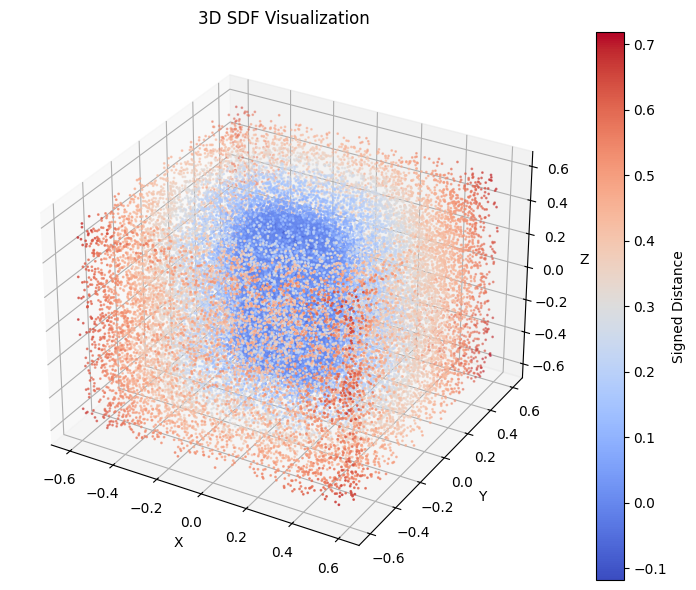

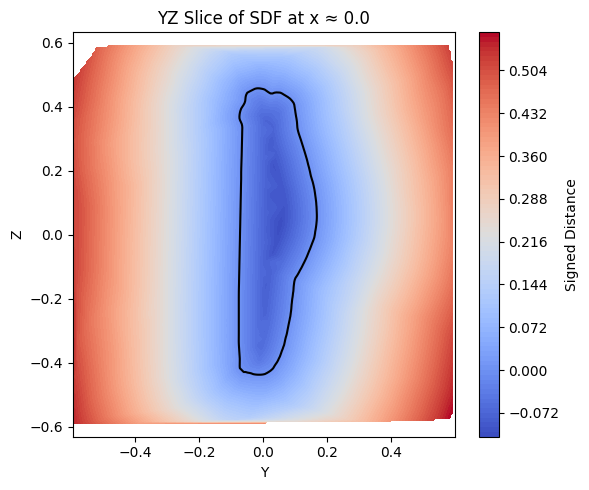

MODEL


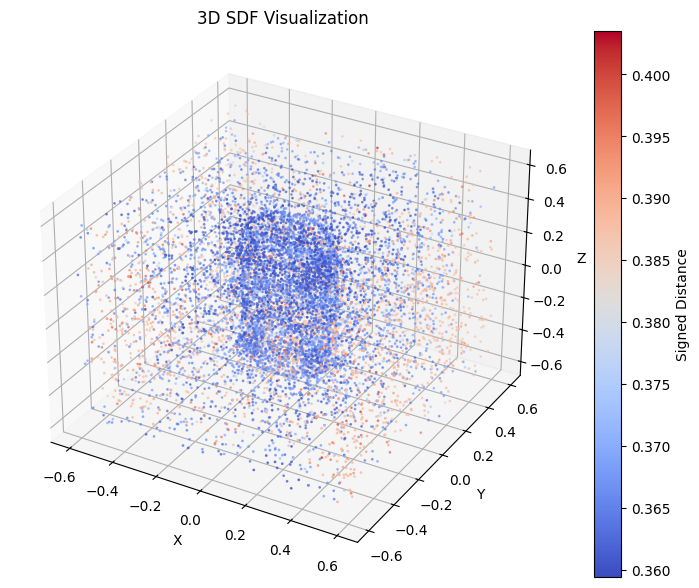

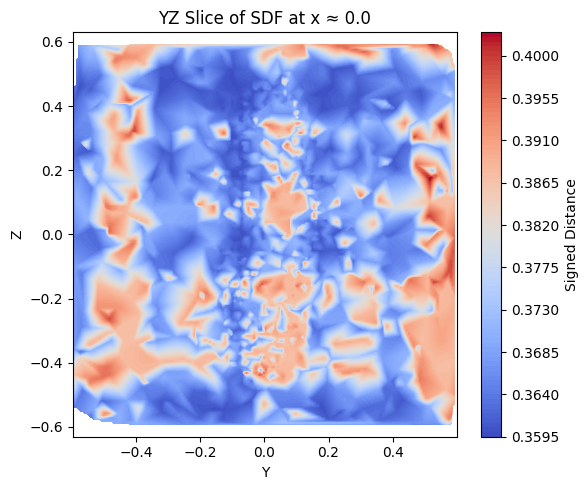

TOTALLY RANDOM


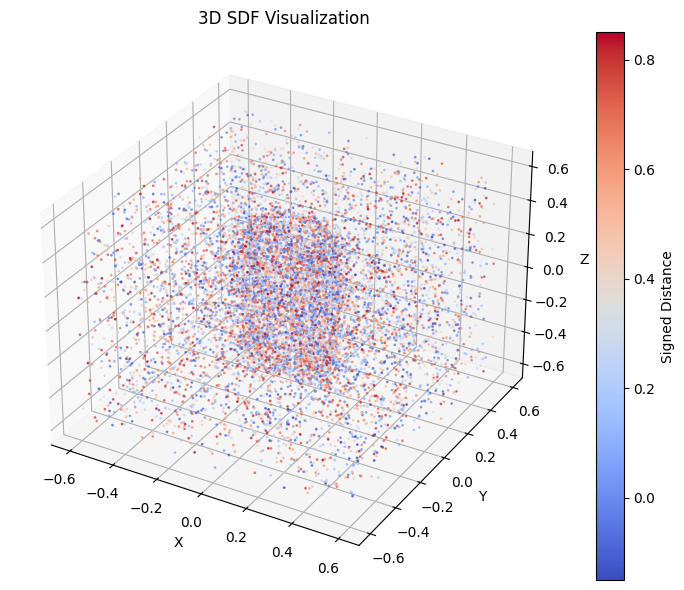

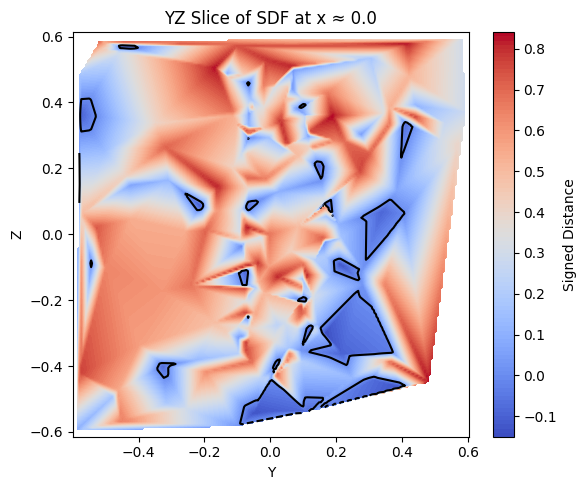

In [91]:
import dataset_utils
model.eval()
example = val_dataset[torch.randint(0, 20, (1,)).item()]

pred = test_model(example).squeeze(0).cpu()
rand = totally_random(example).squeeze(0)

# dataset_utils.visualize_sdf_2d(pred.detach().cpu())
print("TRUE")
dataset_utils.visualize_sdf_3d(example)
dataset_utils.visualize_sdf_2d(example)
print("MODEL")
dataset_utils.visualize_sdf_3d(pred.detach().cpu())
dataset_utils.visualize_sdf_2d(pred.detach().cpu(), tolerance=0.1)
print("TOTALLY RANDOM")
dataset_utils.visualize_sdf_3d(rand)
dataset_utils.visualize_sdf_2d(rand)
